<font size=6>
    <b>Sentiment_Analysis.ipynb:</b> Sentiment Analysis with Pandas and Watson Natural Language Understanding
 </font>

# Introduction

With the significant growth in the volume of highly subjective user-generated text in the form of online products reviews, recommendations, blogs, discussion forums and etc., the sentiment analysis has gained a lot of attention in the last decade. The sentiment analysis goal is to automatically detect the underlying sentiment of the user towards the entity of interest. While the Sentiment analysis is  one of the most prominent and commonly used natural language processing (NLP) features, it is typically used in combination with other NLP features and text analytics to gain insight about the user experience for the sake of customer care and feedback analytics, product analytics and brand intelligence.
This notebook shows how the open source library [Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas) lets you use use [Pandas](https://pandas.pydata.org/) DataFrames and the [Watson Natural Language Understanding](https://www.ibm.com/cloud/watson-natural-language-understanding) service to conduct exploratory sentiment analysis over the product reviews. 

We start out with a dataset from the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews) obtained from the Kaggle datasets. This is a dataset containing consumer's thought and the star rating of car manufacturer/model/type.
We pass each review to the Watson Natural Language 
Understanding (NLU) service. Then we use Text Extensions for Pandas to convert the output of the 
Watson NLU service to Pandas DataFrames. Next, we perform an example exploratory data analysis and machine learning task with 
Pandas to show how Pandas makes analyzing the dataset and prediction task much easier.

# Environment Setup

This notebook requires a Python 3.7 or later environment with the following packages:
* The dependencies listed in the ["requirements.txt" file for Text Extensions for Pandas](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/requirements.txt)
* The "[ibm-watson](https://pypi.org/project/ibm-watson/)" package, available via `pip install ibm-watson`
* `text_extensions_for_pandas`

You can satisfy the dependency on `text_extensions_for_pandas` in either of two ways:

* Run `pip install text_extensions_for_pandas` before running this notebook. This command adds the library to your Python environment.
* Run this notebook out of your local copy of the Text Extensions for Pandas project's [source tree](https://github.com/CODAIT/text-extensions-for-pandas). In this case, the notebook will use the version of Text Extensions for Pandas in your local source tree **if the package is not installed in your Python environment**.

In [1]:
# Core Python libraries
import json
import os
import sys
import pandas as pd
import numpy as np
import glob
import re
import warnings
from typing import *

# IBM Watson libraries
import ibm_watson
import ibm_watson.natural_language_understanding_v1 as nlu
import ibm_cloud_sdk_core

# Machine Learning libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt


# And of course we need the text_extensions_for_pandas library itself.
try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    # If we're running from within the project source tree and the parent Python
    # environment doesn't have the text_extensions_for_pandas package, use the
    # version in the local source tree.
    if not os.getcwd().endswith("notebooks"):
        raise e
    if ".." not in sys.path:
        sys.path.insert(0, "..")
    import text_extensions_for_pandas as tp

# Set up the Watson Natural Language Understanding Service

In this part of the notebook, we will use the Watson Natural Language Understanding (NLU) service to extract the keywords and their sentiment and emotion from each of the product reviews.

You can create an instance of Watson NLU on the IBM Cloud for free by navigating to [this page](https://www.ibm.com/cloud/watson-natural-language-understanding) and clicking on the button marked "Get started free". You can also install your own instance of Watson NLU on [OpenShift](https://www.openshift.com/) by using [IBM Watson Natural Language Understanding for IBM Cloud Pak for Data](
https://catalog.redhat.com/software/operators/detail/5e9873e13f398525a0ceafe5).

You'll need two pieces of information to access your instance of Watson NLU: An **API key** and a **service URL**. If you're using Watson NLU on the IBM Cloud, you can find your API key and service URL in the IBM Cloud web UI. Navigate to the [resource list](https://cloud.ibm.com/resources) and click on your instance of Natural Language Understanding to open the management UI for your service. Then click on the "Manage" tab to show a page with your API key and service URL.

The cell that follows assumes that you are using the environment variables `IBM_API_KEY` and `IBM_SERVICE_URL` to store your credentials. If you're running this notebook in Jupyter on your laptop, you can set these environment variables while starting up `jupyter notebook` or `jupyter lab`. For example:
``` console
IBM_API_KEY='<my API key>' \
IBM_SERVICE_URL='<my service URL>' \
  jupyter lab
```

Alternately, you can uncomment the first two lines of code below to set the `IBM_API_KEY` and `IBM_SERVICE_URL` environment variables directly.
**Be careful not to store your API key in any publicly-accessible location!**

In [2]:
# If you need to embed your credentials inline, uncomment the following two lines and
# paste your credentials in the indicated locations.
# os.environ["IBM_API_KEY"] = "<API key goes here>"
# os.environ["IBM_SERVICE_URL"] = "<Service URL goes here>"

# Retrieve the API key for your Watson NLU service instance
if "IBM_API_KEY" not in os.environ:
    raise ValueError("Expected Watson NLU api key in the environment variable 'IBM_API_KEY'")
api_key = os.environ.get("IBM_API_KEY")
    
# Retrieve the service URL for your Watson NLU service instance
if "IBM_SERVICE_URL" not in os.environ:
    raise ValueError("Expected Watson NLU service URL in the environment variable 'IBM_SERVICE_URL'")
service_url = os.environ.get("IBM_SERVICE_URL")  

# Connect to the Watson Natural Language Understanding Python API

This notebook uses the IBM Watson Python SDK to perform authentication on the IBM Cloud via the 
`IAMAuthenticator` class. See [the IBM Watson Python SDK documentation](https://github.com/watson-developer-cloud/python-sdk#iam) for more information. 

We start by using the API key and service URL from the previous cell to create an instance of the
Python API for Watson NLU.

In [3]:
natural_language_understanding = ibm_watson.NaturalLanguageUnderstandingV1(
    version="2019-07-12",
    authenticator=ibm_cloud_sdk_core.authenticators.IAMAuthenticator(api_key)
)
natural_language_understanding.set_service_url(service_url)
natural_language_understanding.set_disable_ssl_verification(True)

# Pass a Review through the Watson NLU Service

Once you've opened a connection to the Watson NLU service, you can pass documents through 
the service by invoking the [`analyze()` method](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#analyze).

To do so, you should download the [Edmunds-Consumer Car Ratings and Reviews](https://www.kaggle.com/ankkur13/edmundsconsumer-car-ratings-and-reviews/download/) from the Kaggle website and place the archive.zip folder to our notebooks/outputs directory. Note that the directory of the dataset contains 50 csv files of reviews of 50 major car brands which we read into one dataframe with the brand name is listed under the "Car_Make" column.

Let's read the reviews and show what the reviews looks like:

In [4]:
from zipfile import ZipFile
path = r'./outputs/archive' # path to compressed  directorey of data

with ZipFile(path+'.zip', 'r') as zipObj:
   # Extract all the contents of zip file in the notebooks/output/archive directory
   zipObj.extractall(path)
    
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=0, header=0, lineterminator='\n')
    df['Car_Make'] = re.split('_|\\.',os.path.basename(filename))[-2] # Extracting the car brand from file name
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
frame.head(10)

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make
0,on 09/18/11 00:19 AM (PDT),wizbang_fl,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"New Beetle- Holds up well & Fun to Drive, but ...",I've had my Beetle Convertible for over 4.5 y...,4.500,Volkswagen
1,on 07/07/10 05:28 AM (PDT),carlo frazzano,2007 Volkswagen New Beetle Convertible 2.5 PZE...,Quality Review,We bought the car new in 2007 and are general...,4.375,Volkswagen
2,on 10/19/09 21:41 PM (PDT),NewBeetleDriver,2007 Volkswagen New Beetle Convertible Triple ...,Adore it,I adore my New Beetle. Even though I'm a male...,4.375,Volkswagen
3,on 01/01/09 19:13 PM (PST),Kayemtee,2007 Volkswagen New Beetle Convertible 2.5 2dr...,Nice Ragtop,My wife chose this car to replace a Sebring c...,4.375,Volkswagen
4,on 08/02/08 13:43 PM (PDT),jik,2007 Volkswagen New Beetle Convertible 2.5 2dr...,"Luv, luv, luv my dream car",4 of us carpool 1 way 30 min. Backseat ok fo...,4.750,Volkswagen
5,on 05/16/08 12:07 PM (PDT),Ray Cavanagh,2007 Volkswagen New Beetle Convertible Triple ...,The Best One So Far....,I owned a 2002 SLK and 2003 BMW Z-4. After s...,5.000,Volkswagen
6,on 03/28/08 22:04 PM (PDT),harvestmoon,2007 Volkswagen New Beetle Convertible 2.5 2dr...,Don't Fall Under The Cute Spell!,Fell in love with the car's look and would be...,2.750,Volkswagen
7,on 01/03/08 17:53 PM (PST),The Husband,2007 Volkswagen New Beetle Convertible Triple ...,Not for Cold Weather!!!,The car is beautiful and performs well in the...,3.750,Volkswagen
8,on 09/27/07 08:42 AM (PDT),Kristina,2007 Volkswagen New Beetle Convertible 2.5 2dr...,I love my Beetle,I love my car. I previously owned an Explore...,5.000,Volkswagen
9,on 08/01/07 22:24 PM (PDT),bug lover,2007 Volkswagen New Beetle Convertible Triple ...,Bug lover review,"My 2005 was so good, I had to have the Triple...",5.000,Volkswagen


Let's see how many car models, reviews and reviewers and etc. we have per car make in our dataset:

In [5]:
frame.groupby('Car_Make').nunique()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r
Car_Make,,,,,,
AMGeneral,5,5,2,5,5,4
Acura,5632,5807,494,5682,6512,32
AlfaRomeo,77,76,22,77,77,5
AstonMartin,82,89,31,89,89,17
Audi,5069,5389,753,5467,6006,33
BMW,6833,7106,829,7203,7984,33
Bentley,150,146,39,141,150,21
Bugatti,9,9,4,9,9,7
Buick,3406,3242,374,3334,3615,33


And number of the car makes:

In [6]:
frame.groupby('Car_Make').nunique().shape[0]

50

Let's then sample randomly from the dataframe by keeping <=200 of the records per car make:

In [7]:
n = 200
sampled_df = frame.groupby('Car_Make').apply(lambda x: x.sample(min(n,len(x)))).reset_index(drop=True)
sampled_df.nunique()

Review_Date      7263
Author_Name      7387
Vehicle_Title    5281
Review_Title     7646
Review           8322
Rating\r           33
Car_Make           50
dtype: int64

Checking the number of reviews and columns in the imported corpus:

In [8]:
sampled_df.shape

(8392, 7)

Let's combine the review titles and the review into the review_content for the later analysis:

In [9]:
sampled_df['Review_Content'] = sampled_df['Review_Title']+ ':' + sampled_df['Review']
sampled_df.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.000,AMGeneral,What a waste: I have owned this car for a year...
1,on 08/23/03 00:00 AM (PDT),Bobby Keene,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,H1 Review,The truck is incredible. I have a long histo...,4.500,AMGeneral,H1 Review: The truck is incredible. I have a ...
2,on 12/18/05 19:55 PM (PST),Clayton,2000 AM General Hummer SUV 4dr SUV AWD,HUMMER NOT A bummer,Vehicle is a beast. I don't recommend HUMMER ...,5.000,AMGeneral,HUMMER NOT A bummer : Vehicle is a beast. I do...
3,on 01/19/06 19:46 PM (PST),REUBEN,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,AWESOME HUMMER,Hummer is unstoppable. May only get 12 mpg bu...,5.000,AMGeneral,AWESOME HUMMER: Hummer is unstoppable. May onl...
4,on 08/30/02 00:00 AM (PDT),bluice3309,2000 AM General Hummer SUV 4dr SUV AWD,a true ride,this beast can go through just about \ranythi...,4.625,AMGeneral,a true ride: this beast can go through just ab...


Let's see what the reiews look like in our dataset by showing one:

In [10]:
sampled_df['Review_Content'][0]

'What a waste: I have owned this car for a year and a \rhalf now and it is not reliabile at \rall.  I have driven it through \reverything and it stalls on me all the \rtime.  I would never buy this car \ragain.  and trying to sell it is like \rtrying to sell fire in hell, just wont \rhappen.'

# Watson Natural Language Understanding Analysis:
Now it is time to check how Watson Natural Language Understanding can help us analyzing the reviews starting from the first review:

In the code below, we instruct Watson Natural Language Understanding to perform keywords (with sentiment and emotion) analysis on the first review:

See [the Watson NLU documentation](https://cloud.ibm.com/apidocs/natural-language-understanding?code=python#text-analytics-features) for a full description of the types of analysis that NLU can perform.

In [11]:
warnings.filterwarnings('ignore')
# Using Watson Natural Language Understanding for analyzing the Review_Content
# Make the request
nlu_response_review = natural_language_understanding.analyze(
    text=sampled_df['Review_Content'][0],
    return_analyzed_text=True,
    features=nlu.Features(
        keywords=nlu.KeywordsOptions(sentiment=True, emotion=True)
    )).get_result()


The response from the analyze() method is a Python dictionary. The dictionary contains an entry for each pass of analysis requested, plus some additional entries with metadata about the API request itself. Here's a list of the keys in response:

In [12]:
nlu_response_review.keys()

dict_keys(['usage', 'language', 'keywords', 'analyzed_text'])

And here's the whole output of Watson NLU's text analysis for the first review in the dataset:

In [13]:
nlu_response_review

{'usage': {'text_units': 1, 'text_characters': 284, 'features': 1},
 'language': 'en',
 'keywords': [{'text': 'waste',
   'sentiment': {'score': -0.875214, 'label': 'negative'},
   'relevance': 0.685741,
   'emotion': {'sadness': 0.494477,
    'joy': 0.015328,
    'fear': 0.130232,
    'disgust': 0.244124,
    'anger': 0.457683},
   'count': 1},
  {'text': 'fire',
   'sentiment': {'score': -0.934512, 'label': 'negative'},
   'relevance': 0.598326,
   'emotion': {'sadness': 0.283251,
    'joy': 0.010869,
    'fear': 0.116199,
    'disgust': 0.2384,
    'anger': 0.665425},
   'count': 1},
  {'text': 'car',
   'sentiment': {'score': -0.875214, 'label': 'negative'},
   'relevance': 0.581432,
   'emotion': {'sadness': 0.407834,
    'joy': 0.014601,
    'fear': 0.19596,
    'disgust': 0.223132,
    'anger': 0.488137},
   'count': 2},
  {'text': 'hell',
   'sentiment': {'score': 0, 'label': 'neutral'},
   'relevance': 0.577011,
   'emotion': {'sadness': 0.283251,
    'joy': 0.010869,
    'fea

Let's explore the output dictionary based on its keys:

In [14]:
nlu_response_review['analyzed_text']

'What a waste: I have owned this car for a year and a \rhalf now and it is not reliabile at \rall.  I have driven it through \reverything and it stalls on me all the \rtime.  I would never buy this car \ragain.  and trying to sell it is like \rtrying to sell fire in hell, just wont \rhappen.'

In [15]:
nlu_response_review['keywords']

[{'text': 'waste',
  'sentiment': {'score': -0.875214, 'label': 'negative'},
  'relevance': 0.685741,
  'emotion': {'sadness': 0.494477,
   'joy': 0.015328,
   'fear': 0.130232,
   'disgust': 0.244124,
   'anger': 0.457683},
  'count': 1},
 {'text': 'fire',
  'sentiment': {'score': -0.934512, 'label': 'negative'},
  'relevance': 0.598326,
  'emotion': {'sadness': 0.283251,
   'joy': 0.010869,
   'fear': 0.116199,
   'disgust': 0.2384,
   'anger': 0.665425},
  'count': 1},
 {'text': 'car',
  'sentiment': {'score': -0.875214, 'label': 'negative'},
  'relevance': 0.581432,
  'emotion': {'sadness': 0.407834,
   'joy': 0.014601,
   'fear': 0.19596,
   'disgust': 0.223132,
   'anger': 0.488137},
  'count': 2},
 {'text': 'hell',
  'sentiment': {'score': 0, 'label': 'neutral'},
  'relevance': 0.577011,
  'emotion': {'sadness': 0.283251,
   'joy': 0.010869,
   'fear': 0.116199,
   'disgust': 0.2384,
   'anger': 0.665425},
  'count': 1},
 {'text': 'year',
  'sentiment': {'score': -0.875214, 'lab

For many data scientists and machine learning engineers a common task workflow includes using Pandas to do exploratory data analysis followed by using scikit-learn for applying the machine learning techniques over the data. 

Text Extensions for Pandas includes a function parse_response() that turns the output of Watson NLU's analyze() function into a dictionary of Pandas DataFrames. Let's run our response object through that conversion. Let's first begin by parsing the Watson NLU response by text extensions for pandas, to see what information has been captured for each review:

In [16]:
df_analyzed_review = tp.io.watson.nlu.parse_response(nlu_response_review)
df_analyzed_review

{'syntax': Empty DataFrame
 Columns: []
 Index: [],
 'entities': Empty DataFrame
 Columns: []
 Index: [],
 'entity_mentions': Empty DataFrame
 Columns: []
 Index: [],
 'keywords':         text sentiment.label  sentiment.score  relevance  emotion.sadness  \
 0      waste        negative        -0.875214   0.685741         0.494477   
 1       fire        negative        -0.934512   0.598326         0.283251   
 2        car        negative        -0.875214   0.581432         0.407834   
 3       hell         neutral         0.000000   0.577011         0.283251   
 4       year        negative        -0.875214   0.563676         0.494477   
 5  reliabile        negative        -0.665741   0.471689         0.245249   
 6       time        negative        -0.813165   0.471689         0.000000   
 
    emotion.joy  emotion.fear  emotion.disgust  emotion.anger  count  
 0     0.015328      0.130232         0.244124       0.457683      1  
 1     0.010869      0.116199         0.238400       

In [17]:
df_analyzed_review.keys()

dict_keys(['syntax', 'entities', 'entity_mentions', 'keywords', 'relations', 'semantic_roles'])

The output of each analysis pass that Watson NLU performed is now a DataFrame. Let's look at the DataFrame for the "keywords" pass:

In [18]:
df_analyzed_review['keywords']

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count
0,waste,negative,-0.875214,0.685741,0.494477,0.015328,0.130232,0.244124,0.457683,1
1,fire,negative,-0.934512,0.598326,0.283251,0.010869,0.116199,0.238400,0.665425,1
2,car,negative,-0.875214,0.581432,0.407834,0.014601,0.195960,0.223132,0.488137,2
3,hell,neutral,0.000000,0.577011,0.283251,0.010869,0.116199,0.238400,0.665425,1
4,year,negative,-0.875214,0.563676,0.494477,0.015328,0.130232,0.244124,0.457683,1
5,reliabile,negative,-0.665741,0.471689,0.245249,0.024940,0.333530,0.351359,0.345149,1
6,time,negative,-0.813165,0.471689,0.000000,0.000000,0.000000,0.000000,0.000000,1


Buried in the above data structure is all the information we need to perform our sentence-level sentiment analysis task:


 - The sentiment label and score of every sentence in the review. The score ranges from -1 to 1, with -1 being negative, 0 being neutral and 1 being positive. It provides sentiment on each keyword based on its sentence's sentiment, which can come in useful since it calculates the sentiment in the context.
 - The emotion score of every sentence (i.e., sadness, joy, fear, disgust, and anger) in the review.

 - The list of the most important words/phrases in a review including both sentiment/emotion-bearing words/phrases as well as objective words/phrases in the review extracted under the keywords. Note that the sentiment assigned to each keyword has calculated based on its context and in the sentence level.

Now let's concat the watson nlu sentiment analysis dataframe above(output of text enstensions for pandas) with its corresponding review.

In [19]:
keywords_review = pd.concat ([df_analyzed_review['keywords'] , pd.Series([nlu_response_review['analyzed_text']]*len(df_analyzed_review['keywords']))], axis = 1)
keywords_review

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,0
0,waste,negative,-0.875214,0.685741,0.494477,0.015328,0.130232,0.244124,0.457683,1,What a waste: I have owned this car for a year...
1,fire,negative,-0.934512,0.598326,0.283251,0.010869,0.116199,0.238400,0.665425,1,What a waste: I have owned this car for a year...
2,car,negative,-0.875214,0.581432,0.407834,0.014601,0.195960,0.223132,0.488137,2,What a waste: I have owned this car for a year...
3,hell,neutral,0.000000,0.577011,0.283251,0.010869,0.116199,0.238400,0.665425,1,What a waste: I have owned this car for a year...
4,year,negative,-0.875214,0.563676,0.494477,0.015328,0.130232,0.244124,0.457683,1,What a waste: I have owned this car for a year...
5,reliabile,negative,-0.665741,0.471689,0.245249,0.024940,0.333530,0.351359,0.345149,1,What a waste: I have owned this car for a year...
6,time,negative,-0.813165,0.471689,0.000000,0.000000,0.000000,0.000000,0.000000,1,What a waste: I have owned this car for a year...


Let's merge the above dataframe with its corresponding review's information:

In [20]:
(keywords_review.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])

,text,sentiment.label,sentiment.score,relevance,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,count,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,waste,negative,-0.875214,0.685741,0.494477,0.015328,0.130232,0.244124,0.457683,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
1,fire,negative,-0.934512,0.598326,0.283251,0.010869,0.116199,0.238400,0.665425,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
2,car,negative,-0.875214,0.581432,0.407834,0.014601,0.195960,0.223132,0.488137,2,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
3,hell,neutral,0.000000,0.577011,0.283251,0.010869,0.116199,0.238400,0.665425,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
4,year,negative,-0.875214,0.563676,0.494477,0.015328,0.130232,0.244124,0.457683,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
5,reliabile,negative,-0.665741,0.471689,0.245249,0.024940,0.333530,0.351359,0.345149,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
6,time,negative,-0.813165,0.471689,0.000000,0.000000,0.000000,0.000000,0.000000,1,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...


# Repeat the Preprocessing over Multiple Reviews
Let's see how we can apply same operations on multiple entries from our car reviews dataset and use the outcome for correlation and sentiment analysis:

In [21]:
warnings.filterwarnings('ignore')
nlu_response_reviews = sampled_df['Review_Content'].dropna().apply(lambda x: natural_language_understanding.analyze(
        text=x,
        language="en",
        return_analyzed_text=True,
        features=nlu.Features(
            keywords=nlu.KeywordsOptions(sentiment=True, emotion=True,
                                        )
                    )).get_result())


In [22]:
tp_parsed_reviews = [tp.io.watson.nlu.parse_response(r) for r in nlu_response_reviews]

That's it. With the DataFrame version of this data, we can perform our exploratory and sentiment analysis task easily with few line of code.

Specifically, we use Pandas  to concat the Watson NLU sentiments dataframe (output of text enstensions for pandas) with its corresponding review, and then we conduct some exploratory analysis on the data.

In [23]:
# Concatenation
keywords_review = [pd.concat ([parsed_review['keywords'] , pd.Series([r['analyzed_text']]*len(parsed_review['keywords']))], axis = 1) for (parsed_review,r) in zip(tp_parsed_reviews,pd.Series(nlu_response_reviews))]
# Convert list of dataframes to the dataframe
keywords_review_df = pd.concat(keywords_review, axis = 0)
keywords_review_df.head(20)

,0,count,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.label,sentiment.score,text
0,What a waste: I have owned this car for a year...,1.0,0.457683,0.244124,0.130232,0.015328,0.494477,0.685741,negative,-0.875214,waste
1,What a waste: I have owned this car for a year...,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.598326,negative,-0.934512,fire
2,What a waste: I have owned this car for a year...,2.0,0.488137,0.223132,0.195960,0.014601,0.407834,0.581432,negative,-0.875214,car
3,What a waste: I have owned this car for a year...,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.577011,neutral,0.000000,hell
4,What a waste: I have owned this car for a year...,1.0,0.457683,0.244124,0.130232,0.015328,0.494477,0.563676,negative,-0.875214,year
5,What a waste: I have owned this car for a year...,1.0,0.345149,0.351359,0.333530,0.024940,0.245249,0.471689,negative,-0.665741,reliabile
6,What a waste: I have owned this car for a year...,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.471689,negative,-0.813165,time
0,H1 Review: The truck is incredible. I have a ...,1.0,0.013115,0.024451,0.014580,0.721719,0.031339,0.964178,positive,0.970854,H1 Review
1,H1 Review: The truck is incredible. I have a ...,1.0,0.021514,0.055864,0.161380,0.218622,0.279594,0.925094,neutral,0.000000,long history
2,H1 Review: The truck is incredible. I have a ...,1.0,0.106156,0.080733,0.094499,0.122194,0.251278,0.720289,neutral,0.000000,abilities of this truck


Merging each review in the resulted dataframe with its Title, Author, Rating, and other info as below and then grouping based on the Review_Title:

In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
merged_keywords_review_df = (keywords_review_df.merge(sampled_df, left_on=0, right_on = sampled_df.Review_Content)).drop(columns=[0])
grouped_merged_keywords_review_df = merged_keywords_review_df.groupby('Review_Title')
grouped_merged_keywords_review_df.get_group('What a waste').head(30)

,count,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.label,sentiment.score,text,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating\r,Car_Make,Review_Content
0,1.0,0.457683,0.244124,0.130232,0.015328,0.494477,0.685741,negative,-0.875214,waste,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
1,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.598326,negative,-0.934512,fire,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
2,2.0,0.488137,0.223132,0.195960,0.014601,0.407834,0.581432,negative,-0.875214,car,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
3,1.0,0.665425,0.238400,0.116199,0.010869,0.283251,0.577011,neutral,0.000000,hell,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
4,1.0,0.457683,0.244124,0.130232,0.015328,0.494477,0.563676,negative,-0.875214,year,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
5,1.0,0.345149,0.351359,0.333530,0.024940,0.245249,0.471689,negative,-0.665741,reliabile,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...
6,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.471689,negative,-0.813165,time,on 06/15/02 00:00 AM (PDT),mike6382,2000 AM General Hummer SUV Hard Top 4dr SUV AWD,What a waste,I have owned this car for a year and a \rhalf...,1.0,AMGeneral,What a waste: I have owned this car for a year...


As we mentioned above, Watson NLU assigns the sentiment to the keywords based on their context within the sentence. Hence, all keywords within one sentence get the same sentiment score. Thus, to get the aggregated sentiment of each review we calulate the mean sentiment score of its sentences by considering the sentiment assigned to one keyword in each sentence. More specifically, we first drop duplicate sentiment scores for each review and then we calculate the average sentiment and emotion score for each review:

In [25]:
agg_merged_keywords_review_df = merged_keywords_review_df.drop(['count'], axis=1).drop_duplicates(['Review_Title','sentiment.score']).groupby('Review_Title').mean()
agg_merged_keywords_review_df.head(20)

,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.score,Rating\r
Review_Title,,,,,,,,
2008 accent big gas saver,0.031533,0.004556,0.020493,0.464120,0.033524,0.784818,0.887061,5.000
My Montana,0.072422,0.050340,0.035863,0.310516,0.109102,0.614102,0.727699,5.000
Best thing since sliced bread,0.123121,0.056158,0.120696,0.489847,0.142038,0.817214,-0.132941,4.500
I like Toyotas. However...,0.052747,0.024244,0.099708,0.281386,0.266470,0.636949,0.022462,4.500
I love my Caliber,0.057248,0.040379,0.049315,0.604041,0.187137,0.646224,0.919963,4.750
My favorite 4G63-powered car yet,0.123950,0.093661,0.139818,0.184951,0.196913,0.584103,0.529229,4.875
Nothing But Problems....Throw-Away Cars,0.512625,0.133074,0.081369,0.059428,0.485676,0.798629,-0.899683,1.625
Suburu take notes,0.349527,0.077107,0.092011,0.234967,0.154662,0.613862,-0.000559,4.875
very good car,0.058215,0.018780,0.025355,0.544707,0.047769,0.959728,0.499275,4.875


Now we can find the correlation among the variables using pearson method:

In [26]:
corr = agg_merged_keywords_review_df.corr(method ='pearson')
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.score,Rating
emotion.anger,1.00,0.46,0.45,-0.53,0.48,-0.15,-0.56,-0.42
emotion.disgust,0.46,1.00,0.29,-0.45,0.39,-0.17,-0.43,-0.32
emotion.fear,0.45,0.29,1.00,-0.51,0.47,-0.14,-0.49,-0.34
emotion.joy,-0.53,-0.45,-0.51,1.00,-0.64,0.23,0.71,0.48
emotion.sadness,0.48,0.39,0.47,-0.64,1.00,-0.17,-0.68,-0.50
relevance,-0.15,-0.17,-0.14,0.23,-0.17,1.00,0.16,0.10
sentiment.score,-0.56,-0.43,-0.49,0.71,-0.68,0.16,1.00,0.63
Rating,-0.42,-0.32,-0.34,0.48,-0.50,0.10,0.63,1.00


As the table above shows, there is an association between the review's Ratings and the Watson NLU sentiment score and joy emotion but repulsion between review's Ratings and sadness emotion. The results also demonstrate the strong positive correlation between Watson NLU sentiment score and Watson NLU joy emotion. In contrary, there is a strong negative correlation between sadness emotion and the sentiment score as expected.

# Univariate linear regression

Now let's perform the regression. To do that, we first need to determine the input features. Since the sentiment.score field shows a relatively high correlation with the rating, let's try a regression based on just that value:

In [27]:
X = agg_merged_keywords_review_df.dropna()['sentiment.score'].values.reshape(-1, 1)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

Now let's split the dataframe into training and testing sets:

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

We now need to create an instance of the LinearRegression model from Scikit-Learn:

In [29]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

Now that the model has been fit we can make predictions by calling the predict command. We are making predictions on the testing set:

In [30]:
Y_pred = linear_regressor.predict(X_test) # make predictions

We'll now check the predictions against the actual values by using the mean squared error (MSE) and R-2 metrics, two metrics commonly used to evaluate regression tasks:

In [31]:
test_set_mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {test_set_mse}")
test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.5186770375928597
R-Squared = 0.3846455884603224


# Multivariate Linear Regression

Now let's try adding the fine-grained sentiment scores from Watson to our model and see if the coefficient of determination (r^2) goes up

Let's determine the input features:

In [32]:
X_df = agg_merged_keywords_review_df.dropna().iloc[:, :7]
X_df.head()

,emotion.anger,emotion.disgust,emotion.fear,emotion.joy,emotion.sadness,relevance,sentiment.score
Review_Title,,,,,,,
2008 accent big gas saver,0.031533,0.004556,0.020493,0.464120,0.033524,0.784818,0.887061
My Montana,0.072422,0.050340,0.035863,0.310516,0.109102,0.614102,0.727699
Best thing since sliced bread,0.123121,0.056158,0.120696,0.489847,0.142038,0.817214,-0.132941
I like Toyotas. However...,0.052747,0.024244,0.099708,0.281386,0.266470,0.636949,0.022462
I love my Caliber,0.057248,0.040379,0.049315,0.604041,0.187137,0.646224,0.919963


In [33]:
X = X_df.values.reshape(-1, 7)  # values converts it into a numpy array
Y = agg_merged_keywords_review_df.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=9)

In [35]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, Y_train)  # fit the model on the training data

LinearRegression()

In [36]:
Y_pred = linear_regressor.predict(X_test) # make predictions

In [37]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {mse}")
test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.5034998693695305
R-Squared = 0.40265166303853883


Our multivariate model shows better value of Coefficient of determination or R-squared and hence the better fit.

For every feature we get the coefficient value. Since we have 7 features we get 7 coefficients. Magnitude and direction(+/-) of all these values affect the prediction results. 

In [38]:
coef = linear_regressor.coef_
print(f"Feature Coefficients = {coef}")
linear_regressor.intercept_

Feature Coefficients = [[-1.12512712 -0.49705717  0.1461738   0.08924407 -0.78849839 -0.16724938
   0.98246023]]


array([4.4610253])

# Predicted Rating against actual Rating plot
We have our predictions in Y_pred. Now lets first create a dataframe for the prediction and actual ratings and then visualize it:

In [39]:
predicted_actual = pd.DataFrame(zip(np.squeeze(Y_pred), np.squeeze(Y)), columns=['Predicted Rating', 'Actual Rating'])
predicted_actual

,Predicted Rating,Actual Rating
0,3.724789,5.000
1,5.341971,5.000
2,5.146892,4.500
3,4.640527,4.500
4,4.709944,4.750
...,...,...
1524,3.659133,3.250
1525,3.272014,4.875
1526,4.528723,3.750
1527,3.969028,4.875


Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

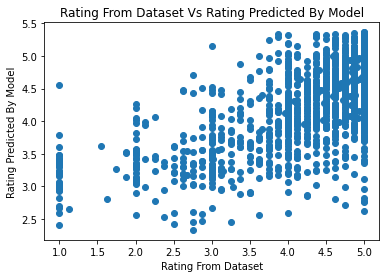

In [40]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Random Forest:

Let's fit Random forest regressor to the dataset to see if can improve the R-squared value even more:

In [41]:
# Fitting Random Forest Regression to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor
  
# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
  
# fit the regressor with x and y data
regressor.fit(X_train, Y_train)  

RandomForestRegressor(random_state=0)

Predicting a new result:

In [42]:
Y_pred = regressor.predict(X_test)  # test the output by changing values

Reporting mean squared error and R-2 score:

In [43]:
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error = {mse}")

test_set_r2 = r2_score(Y_test, Y_pred)
print(f"R-Squared = {test_set_r2}")

Mean Squared Error = 0.45775377881343743
R-Squared = 0.45692446980289403


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

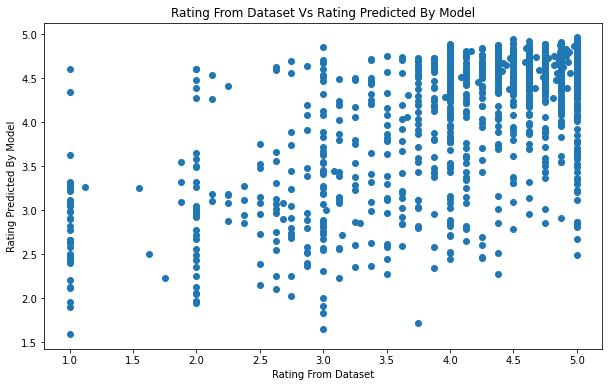

In [44]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Gradient Boosting

Let's try the Gradient Boosting here:

In [45]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print(f"Mean Squared Error = {mean_squared_error(Y_test, Y_pred)}")
print(f"R-Squared = {r2_score(Y_test, Y_pred)}")

Mean Squared Error = 0.4382032073131816
R-Squared = 0.4801191160834333


# Predicted against actual Y plot

Text(0.5, 1.0, 'Rating From Dataset Vs Rating Predicted By Model')

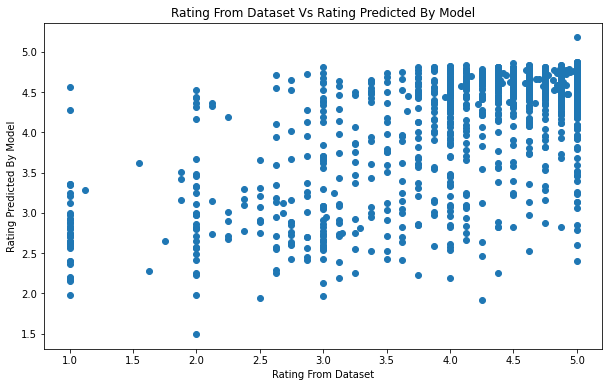

In [46]:
plt.scatter(Y_test, Y_pred)
plt.xlabel('Rating From Dataset')
plt.ylabel('Rating Predicted By Model')
plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
plt.title("Rating From Dataset Vs Rating Predicted By Model")

# Further Evaluations

Let's see how well the model fits the data when it comes to prediction of the Car_Make level ratings. For that we need to keep the Car_Make in our dataset datarame; fit the regression on individual reviews and then calulate the average mean squared error and R-squared in the Car_Make level:

In [47]:
pd.set_option("display.max_colwidth", 10000)
agg_merged_keywords_review_df = merged_keywords_review_df.drop_duplicates(['Review_Title','sentiment.score']).groupby(["Review_Title"]).agg({
                       'sentiment.score': 'mean',
                       'emotion.sadness': 'mean',
                       'emotion.joy': 'mean',
                       'emotion.fear': 'mean',
                       'emotion.disgust': 'mean',
                       'emotion.anger': 'mean',
                       'Rating\r': 'first',
                       'Car_Make': 'first',
                       'Review_Content': 'first'
})
agg_merged_keywords_review_df.head(10)

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Car_Make,Review_Content
Review_Title,,,,,,,,,
2008 accent big gas saver,0.887061,0.033524,0.464120,0.020493,0.004556,0.031533,5.000,hyundai,"2008 accent big gas saver: I bought this car for commuting in the NYC area I own a 07 silverado its a Nice truck but too much fuel this 08 accent took care of that its a pleasure to drive love the radio XM the air its always ice cold 6 airbags love the warranty had to pay extra for my gm one its a Nice car for the price got mine for 13,500 had pinstripe on it front rear mats cargo net and rear cargo mat thanks Hyundai keep up the good work got 600 miles on it no problems."
My Montana,0.727699,0.109102,0.310516,0.035863,0.050340,0.072422,5.000,pontiac,My Montana: I just bought a new Montana and would \rnot buy anything else. The ease the \rhandling and the style of the montana \rcompare to no other min van \rclassification. To top it off all the \rrepair bills I had on the other one was \roil changes no major repairs that is \rreliability. Thanks Pontiac for making \rsuch a great car!
Best thing since sliced bread,-0.132941,0.142038,0.489847,0.120696,0.056158,0.123121,4.500,pontiac,"Best thing since sliced bread: I just bought my wife a 02 grand prix gt.... and it rocks.... sure since it is used and has about 65000 miles on it.... there are a few minor issues... but for a used car, I never would have thought I would feel safe sending my wife the 150 miles to the beach without me.."
I like Toyotas. However...,0.022462,0.266470,0.281386,0.099708,0.024244,0.052747,4.500,Toyota,"I like Toyotas. However...: First year my battery died off, first year had a new transmission to my XLE limited edition. Year and a half, had a new ac compressor. Third year, starting to have problems with my transmission again. I bought the vehicle brand new. I just can not believe this. I think very highly about Toyotas: there quality is the best. I just got a bad one, unfortunately."
I love my Caliber,0.919963,0.187137,0.604041,0.049315,0.040379,0.057248,4.750,dodge,"I love my Caliber: I just bought my Caliber this week So far it has been a blast to drive. I was so surprised how much pep it's got for a small engine. It's also very smooth, you don't even feel the gear shift, I love that. I also love the way it feels like an SUV but looks like a sporty car. So far I love everything about it."
My favorite 4G63-powered car yet,0.529229,0.196913,0.184951,0.139818,0.093661,0.123950,4.875,mitsubishi,"My favorite 4G63-powered car yet: I have put over 196K miles on my '95 \rEclipse GST (stock 4G63 engine and \rturbo). Now that I have a wife and 5 \ryear old twins, I need something \rlarger. My wife wanted my to get a \rLexus IS300. I wanted a EVO. Once I \rgot my wife to test drive the EVO, she \rwas sold. Also, she doesn't mind the \rlooks and comments she get from passer-\rbyes. This is by far one the most fun \rcars I have driven. It is an absolute \rpleasure to drive... power, handling, \rbrakes and exceptional feel. I will \rcontinue to use my '95 Eclipe to \rcommute to work, and see how many miles \rit will go. The EVO will drug of choice \rfor the weekends... putting a smile on \rface each time I drive it."
Nothing But Problems....Throw-Away Cars,-0.899683,0.485676,0.059428,0.081369,0.133074,0.512625,1.625,mini,"Nothing But Problems....Throw-Away Cars: THOSE CARS ARE GARBAGEI would give them ""0"" stars if I could.....Very long story but I will keep this brief .Just picked up my 7 month old car which has been shopped on 4 different occasions 31 days and a full car payment, not to include the days spent sitting in they lot before getting diagnosed..... Twice for tires, run flats suck btw, once for water/ coolant pump failure (replaced with refurbished pump) lastly for new engine........yes I said it new engine.....11,500 milesThe service manager tried to blame me initially, stated that mini wouldn't cover a new engine repai

In [48]:
train_set = agg_merged_keywords_review_df.sample(frac=0.75, random_state=0)
test_set = agg_merged_keywords_review_df.drop(train_set.index)

In [49]:
train_set.groupby("Car_Make").size()

Car_Make
AMGeneral          3
Acura            142
AlfaRomeo         56
AstonMartin       68
Audi             159
BMW              142
Bentley          104
Bugatti            7
Buick            141
Cadillac         145
Chevrolet        143
GMC              144
Honda            133
Toyota           137
Volkswagen       134
chrysler         137
dodge            131
ferrari          105
fiat             135
ford             135
genesis           51
hummer           149
hyundai          147
infiniti         141
isuzu            131
jaguar           140
jeep             128
kia              132
lamborghini       58
land-rover       136
lexus            140
lincoln          140
lotus             95
maserati         128
maybach           11
mazda            136
mclaren            1
mercedes-benz    129
mercury          128
mini             130
mitsubishi       131
nissan           133
pontiac          137
porsche          136
ram              137
rolls-royce       23
subaru           130
suzu

In [50]:
X_train = train_set.dropna().iloc[:, :6].values.reshape(-1, 6)  # values converts it into a numpy array
X_test = test_set.dropna().iloc[:, :6].values.reshape(-1, 6)  # values converts it into a numpy array
Y_train = train_set.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
Y_test = test_set.dropna()['Rating\r'].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column

In [51]:
reg = GradientBoostingRegressor(random_state=0)  # create object for the class
reg.fit(X_train, Y_train)  # fit the model on the training data
Y_pred = reg.predict(X_test) # make predictions

In [52]:
test_set['Predicted_Y'] = Y_pred

In [53]:
agg_grouped_test_set = test_set.groupby('Car_Make').agg(['mean'])
agg_grouped_test_set

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Predicted_Y
,mean,mean,mean,mean,mean,mean,mean,mean
Car_Make,,,,,,,,
AMGeneral,-0.594638,0.234727,0.020143,0.201849,0.161903,0.283711,3.000000,3.288372
Acura,0.269139,0.223486,0.339823,0.105414,0.089589,0.108644,4.485577,4.359534
AlfaRomeo,0.113014,0.204824,0.358904,0.112933,0.069034,0.127305,4.210526,4.243791
AstonMartin,0.273565,0.216167,0.331981,0.113780,0.081419,0.111995,4.300000,4.419518
Audi,0.301738,0.184165,0.366224,0.107866,0.055994,0.102378,4.444444,4.397113
BMW,0.287059,0.186298,0.358934,0.114827,0.059158,0.102991,4.670673,4.406423
Bentley,0.494504,0.178603,0.420438,0.104679,0.079952,0.129632,4.410156,4.603651
Bugatti,0.223715,0.131568,0.400147,0.147350,0.096441,0.140196,4.625000,4.545418


In [54]:
# To get the number of reviews per Car Name:
test_set.groupby('Car_Make').nunique()

,sentiment.score,emotion.sadness,emotion.joy,emotion.fear,emotion.disgust,emotion.anger,Rating\r,Review_Content,Predicted_Y
Car_Make,,,,,,,,,
AMGeneral,2,2,2,2,2,2,2,2,2
Acura,52,52,52,52,52,52,14,52,47
AlfaRomeo,19,19,19,19,19,19,5,19,19
AstonMartin,20,20,20,20,20,20,10,20,20
Audi,36,36,36,36,36,36,13,36,33
BMW,52,52,52,52,52,52,10,52,52
Bentley,32,32,32,32,32,32,11,32,32
Bugatti,2,2,2,2,2,2,2,2,2
Buick,51,51,51,51,51,51,18,51,48


In [56]:
# r2_score for predicted y and target y avg per group!
agg_r2_score = r2_score(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(f"R-Squared = {agg_r2_score}")
agg_mse = mean_squared_error(agg_grouped_test_set['Rating\r'], agg_grouped_test_set['Predicted_Y'])
print(f"Mean Squared Error = {agg_mse}")

R-Squared = 0.708970129519924
Mean Squared Error = 0.029317947789370014


As the mean_squared error shows when it comes to the average the model has fitted the data moderately well. The R-squareds shows a moderate effect size indicates that ~44% of the variability in the Rating cannot be explained by the model.

In [57]:
agg_grouped_test_set[['Rating\r', 'Predicted_Y']]

,Rating\r,Predicted_Y
,mean,mean
Car_Make,,
AMGeneral,3.000000,3.288372
Acura,4.485577,4.359534
AlfaRomeo,4.210526,4.243791
AstonMartin,4.300000,4.419518
Audi,4.444444,4.397113
BMW,4.670673,4.406423
Bentley,4.410156,4.603651
Bugatti,4.625000,4.545418


y = 0.58x + 1.79


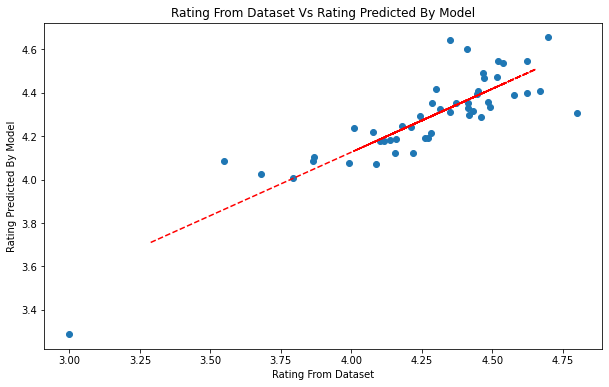

In [58]:
import matplotlib.pylab as pylab

# plot the data itself
pylab.plot(agg_grouped_test_set['Rating\r'],agg_grouped_test_set['Predicted_Y'],'o')
pylab.xlabel('Rating From Dataset')
pylab.ylabel('Rating Predicted By Model')

# calc the trendline
z = np.polyfit(np.squeeze(agg_grouped_test_set['Rating\r']), np.squeeze(agg_grouped_test_set['Predicted_Y']), 1)
p = np.poly1d(z)
pylab.plot(agg_grouped_test_set['Predicted_Y'],p(agg_grouped_test_set['Predicted_Y']),"r--")
pylab.title("Rating From Dataset Vs Rating Predicted By Model")
# the trendline equation:
print ("y = %.2fx + %.2f"%(z[0],z[1]))

The above results suggest a clear better fit for the model in average; showing that the Gradient Boosting Regressor model explains 74% of the fitted Car Make level Rating in the regression model.

# Conclusion

In this notebook we demonstrated how Text Extensions for Pandas can be used to perform Sentiment Analysis tasks. We started by loading our car reviews and passing it through Watson NLU service. We extracted the keywords and their corresponding sentiment and fine-grained emotion using the Watson NLU service. We used Text Extensions for Pandas to convert the Watson NLU output to pandas dataframe and calculated the reveiw-level sentiment and emotion. Using the resulted Pandas dataframe, we showed the correlation of Watson NLU's extracted features and user's Rating first and then developed the Univariate/Multivariate Regression, Random Forest, and Gradient Boosting models for predicting the Ratings for a given review. Finally we evaluated the ability of the model for predicting the sentiment for each car make.

This notebook also demonstrates how easy it is to use IBM Watson NLU, Pandas, Scikit Learn together to conduct exploratory analysis or predcition on your data.